In [1]:
import torch
import torch.nn.functional as F
from enum import Enum

from torchvision.io import read_image
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import matplotlib.pyplot as plt
import numpy as np

from hiera import hiera_base_224, Hiera
from hiera_utils import pretrained_model

device='cuda'
dtype=torch.float32

%load_ext autoreload
%autoreload 2


In [2]:
checkpoints = {
    "example_checkpoint": "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth"
}

@pretrained_model(checkpoints, default="example_checkpoint")
def create_hiera_model():
    return Hiera(input_size=(256,256), num_classes=10)

In [3]:
from decoder import FPNSegmentationHead

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = create_hiera_model()
        self.decoder = FPNSegmentationHead(768, 1, decode_intermediate_input=False, shortcut_dims=[96,192,384,768])
        
    def forward(self, x):
        intermediates = self.encoder(x, return_intermediates=True)
        shortcuts = []
        for i in intermediates:
            shortcuts.append(i.permute(0, 3, 1, 2))
        x = self.decoder([shortcuts[-1]], shortcuts)
        return x

In [6]:
### Change once Dataloader is made ###
img = read_image('assets/107.jpg')
mask = read_image('assets/107.png')

transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
test_transform = transforms.Resize((256,256))

sample = transform(img.to(dtype)) / 255.
mask = test_transform(mask.to(dtype))

sample = sample.to(device)
mask = mask.to(device)

sample = sample.unsqueeze(0)
mask = mask.unsqueeze(0)
### Change once Dataloader is made ###

m = Model().to(device)

optim = torch.optim.Adam(m.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

# repeat training for number of steps
output_size = [256, 256]

for _ in range(100):
    optim.zero_grad()
    out = m(sample) # output is mask of shape 64x64, so we interpolate it to 256x256
    pred_id_logits = torch.nn.functional.interpolate(out,
                                   size=output_size,
                                   mode="bilinear",
                                   align_corners=True)
    loss = loss_fn(pred_id_logits, mask)
    print(loss.item())
    loss.backward()
    optim.step()

-97.49237823486328
-558.7882690429688
-842.6390380859375
-956.4927368164062
-1001.8419189453125
-1032.633544921875
-1058.629638671875
-1084.0748291015625
-1112.523193359375
-1147.225830078125
-1190.744873046875
-1246.425537109375
-1286.933349609375
-1344.478271484375
-1372.308349609375
-1406.13037109375
-1417.013916015625
-1449.182861328125
-1478.517822265625
-1500.813720703125
-1532.3504638671875
-1571.335693359375
-1604.4871826171875
-1629.99365234375
-1665.456298828125
-1695.3751220703125
-1722.808349609375
-1761.1231689453125
-1797.39306640625
-1847.70751953125
-1906.073974609375
-1897.491455078125
-1953.7867431640625
-1866.491455078125
-1855.08935546875
-1875.6414794921875
-1983.4552001953125
-1928.759765625
-1931.102783203125
-2031.6656494140625
-2061.9365234375
-2049.408203125
-2099.87451171875
-2178.77685546875
-2170.0126953125
-2189.255859375
-2236.765625
-2232.249267578125
-2248.4443359375
-2289.00927734375
-2319.025390625
-2324.2177734375
-2342.17578125
-2376.9208984375
-239

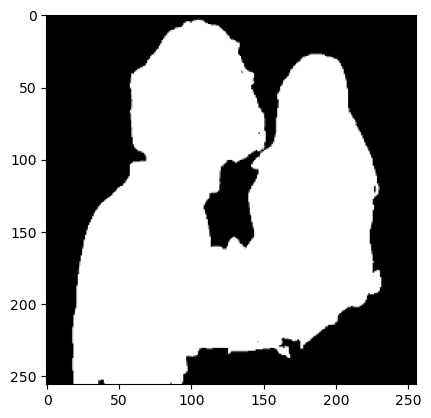

In [12]:
# This will change once DataLoader is created
img = read_image('assets/107.jpg')
mask = read_image('assets/107.png')

transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
test_transform = transforms.Resize((256,256))

sample = transform(img.to(dtype)) / 255.
mask = test_transform(mask.to(dtype))

plt.imshow(mask.permute(1, 2, 0), cmap='gray')

sample = sample.to(device)
mask = mask.to(device)

sample = sample.unsqueeze(0)
mask = mask.unsqueeze(0)
# This will change once DataLoader is created


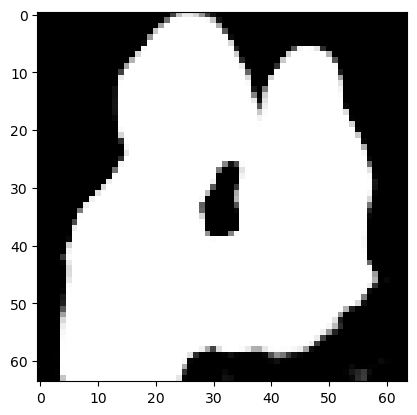

In [13]:
# This will change once DataLoader is created
with torch.no_grad():
    m.eval()
    pred = torch.sigmoid(m(sample))
    pred_mask = pred.squeeze().cpu().numpy()
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

# This will change once DataLoader is created